<a href="https://colab.research.google.com/github/YeshwanthSadum/Machine-Learning/blob/main/Image_classification_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd

In [8]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [9]:
# Mount Google drive folder
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [10]:
print('hello world')

hello world


In [11]:
BATCH_SIZE = 4
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/brain_tumor_dataset",
    seed=123,
    shuffle=True,
    #image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 253 files belonging to 2 classes.


In [13]:
class_names = dataset.class_names
class_names


['no', 'yes']

In [14]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(4, 256, 256, 3)
[1 0 1 1]


plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(5):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

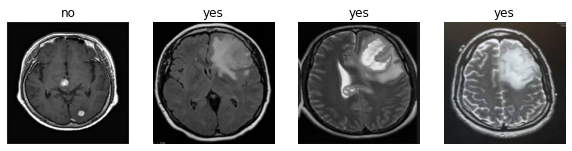

In [15]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [16]:
32*8

256

In [17]:
train_size = 0.8
len(dataset)*train_size

51.2

In [18]:
train_ds = dataset.take(54)
len(train_ds)

54

In [19]:
test_ds = dataset.skip(54)
len(test_ds)

10

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [24]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
# train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (4, 256, 256, 3)          0         
                                                                 
 sequential_1 (Sequential)   (4, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (4, 254, 254, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2D  (4, 127, 127, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (4, 125, 125, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (4, 62, 62, 64)          0         
 2D)                                                  

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
38/38 [==============================] - 25s 37ms/step - loss: 0.6492 - accuracy: 0.6776 - val_loss: 0.5078 - val_accuracy: 0.7292
Epoch 2/50
38/38 [==============================] - 1s 14ms/step - loss: 0.5915 - accuracy: 0.7171 - val_loss: 0.5130 - val_accuracy: 0.7292
Epoch 3/50
38/38 [==============================] - 1s 14ms/step - loss: 0.5347 - accuracy: 0.7632 - val_loss: 0.6397 - val_accuracy: 0.6458
Epoch 4/50
38/38 [==============================] - 1s 14ms/step - loss: 0.5284 - accuracy: 0.7632 - val_loss: 0.5101 - val_accuracy: 0.7292
Epoch 5/50
38/38 [==============================] - 1s 14ms/step - loss: 0.4936 - accuracy: 0.7566 - val_loss: 0.4894 - val_accuracy: 0.7292
Epoch 6/50
38/38 [==============================] - 1s 14ms/step - loss: 0.4791 - accuracy: 0.7566 - val_loss: 0.5187 - val_accuracy: 0.7500
Epoch 7/50
38/38 [==============================] - 1s 14ms/step - loss: 0.5079 - accuracy: 0.7895 - val_loss: 0.4952 - val_accuracy: 0.7292
Epoch 8/50
3

In [30]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 1s 6ms/step - loss: 0.2100 - accuracy: 0.9286


In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

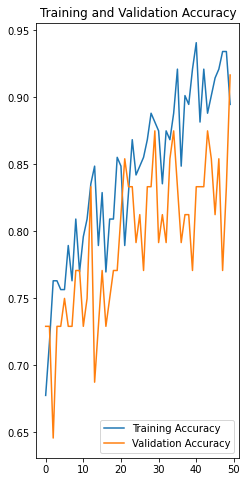

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


first image to predict
actual label: no
predicted label: no


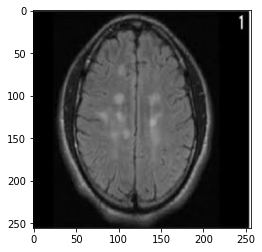

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

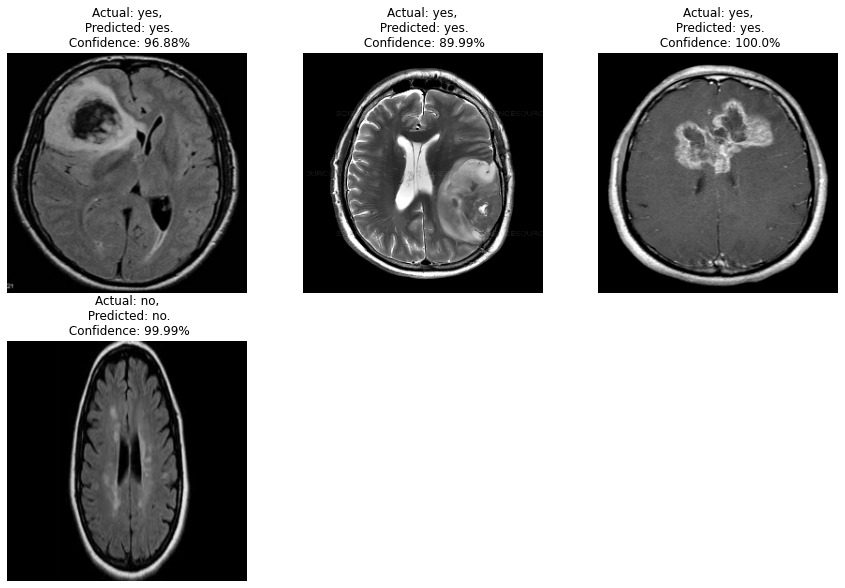

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")